### Sleep Disorder Data Transformation


In [1]:
import os

In [2]:
%pwd

'd:\\Projects\\Sleeping_disorder_detection\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\Projects\\Sleeping_disorder_detection'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass
class DataTransformConfig:
    root_dir: Path
    preprocessor_dir: Path
    preprocessor_file: Path
    train_data_file: Path
    test_data_file: Path

In [6]:
from sleep_disorder.utils.common import read_yaml, create_directories
from sleep_disorder.constants import *

In [7]:
class ConfigurationManager:
    def __init__(self, config_file_path=CONFIG_FILE_PATH, params_file_path=PARAMS_FILE_PATH):
        self.config = read_yaml(config_file_path)
        self.params = read_yaml(params_file_path)

    def get_data_transform_config(self) -> DataTransformConfig:
        config = self.config.data_transform

        data_transform_config = DataTransformConfig(
            root_dir=config.root_dir,
            preprocessor_dir=config.preprocessor_dir,
            preprocessor_file=config.preprocessor_file,
            train_data_file=config.train_data_file,
            test_data_file=config.test_data_file,
        )

        return data_transform_config

#### Importing Libraries


In [8]:
from sleep_disorder.logging import logger

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [11]:
class DataTransform:
    def __init__(self, config: DataTransformConfig):
        self.config = config

        create_directories([self.config.root_dir, self.config.preprocessor_dir])

    def get_local_data(self) -> pd.DataFrame:
        local_data_file = os.path.join("artifacts", "data_ingestion", "local_data.csv")

        df = pd.read_csv(local_data_file)

        return df

    def get_data_transform(self, df: pd.DataFrame):
        df = df.drop(columns='Person ID')
        df['Sleep Disorder'].fillna("No", inplace=True)
        df['BP Ratio'] = df['Blood Pressure'].apply(lambda x: round(float(x.split("/")[0]) / float(x.split("/")[1]), 2))
        X = df.drop(columns=['Sleep Disorder', 'Blood Pressure'])
        y = df['Sleep Disorder']
        cate_col = X.select_dtypes(include='object').columns
        num_col = X.select_dtypes(exclude='object').columns
        cate_pipe = Pipeline([("OneHotEncoder", OneHotEncoder())])

        preprocessor = ColumnTransformer([("cate", cate_pipe, cate_col)])

        X_cate = preprocessor.fit_transform(X[cate_col])
        X_cate = pd.DataFrame.sparse.from_spmatrix(X_cate, columns=preprocessor.get_feature_names_out())

        X = pd.concat([X[num_col], X_cate], axis=1)
        y = y.replace({"No": 0, "Sleep Apnea": 1, "Insomnia": 2})
        data = pd.concat([X, y], axis=1)
        train, test = train_test_split(data, test_size=0.3)

        return preprocessor, train, test

    def dump_preprocessor(self, processor):
        with open(self.config.preprocessor_file, "wb") as pkl_file:
            pickle.dump(processor, pkl_file)
            logger.info(f"Preprocessor Saved to path: {self.config.preprocessor_file}")

    def save_train_test_file(self, train: pd.DataFrame, test: pd.DataFrame):
        try:
            train.to_csv(self.config.train_data_file, index=False)
            logger.info(f"Train Data Saved to path: {self.config.train_data_file}")
            test.to_csv(self.config.test_data_file, index=False)
            logger.info(f"Test Data Saved to path: {self.config.train_data_file}")
        except Exception as e:
            raise e

#### STEP-1 Reading Data


In [12]:
try:
    config = ConfigurationManager()
    data_transform_config = config.get_data_transform_config()
    data_transform = DataTransform(config=data_transform_config)
    df = data_transform.get_local_data()
    processor, train, test = data_transform.get_data_transform(df=df)
    data_transform.dump_preprocessor(processor=processor)
    data_transform.save_train_test_file(train=train, test=test)
except Exception as e:
    raise e

[2023-12-21 03:19:51,070]: INFO common yaml file: config\config.yaml loaded successfully.
[2023-12-21 03:19:51,073]: INFO common yaml file: params.yaml loaded successfully.
[2023-12-21 03:19:51,076]: INFO common Directory created at: artifacts/data_transform
[2023-12-21 03:19:51,077]: INFO common Directory created at: preprocessor
[2023-12-21 03:19:51,103]: INFO 3994698202 Preprocessor Saved to path: preprocessor/preprocessor.pkl
[2023-12-21 03:19:51,113]: INFO 3994698202 Train Data Saved to path: artifacts/data_transform/train_data.csv
[2023-12-21 03:19:51,119]: INFO 3994698202 Test Data Saved to path: artifacts/data_transform/train_data.csv


#### STEP-2 Data Preprocessing and EDA


In [13]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [14]:
df = df.drop(columns='Person ID')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Blood Pressure           374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 35.2+ KB


In [16]:
df.shape

(374, 12)

In [17]:
df.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


#### Checking for null values


In [18]:
df.isnull().sum()[df.isnull().sum() > 0]

Sleep Disorder    219
dtype: int64

In [19]:
df['Sleep Disorder'].fillna("No", inplace=True)

In [20]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

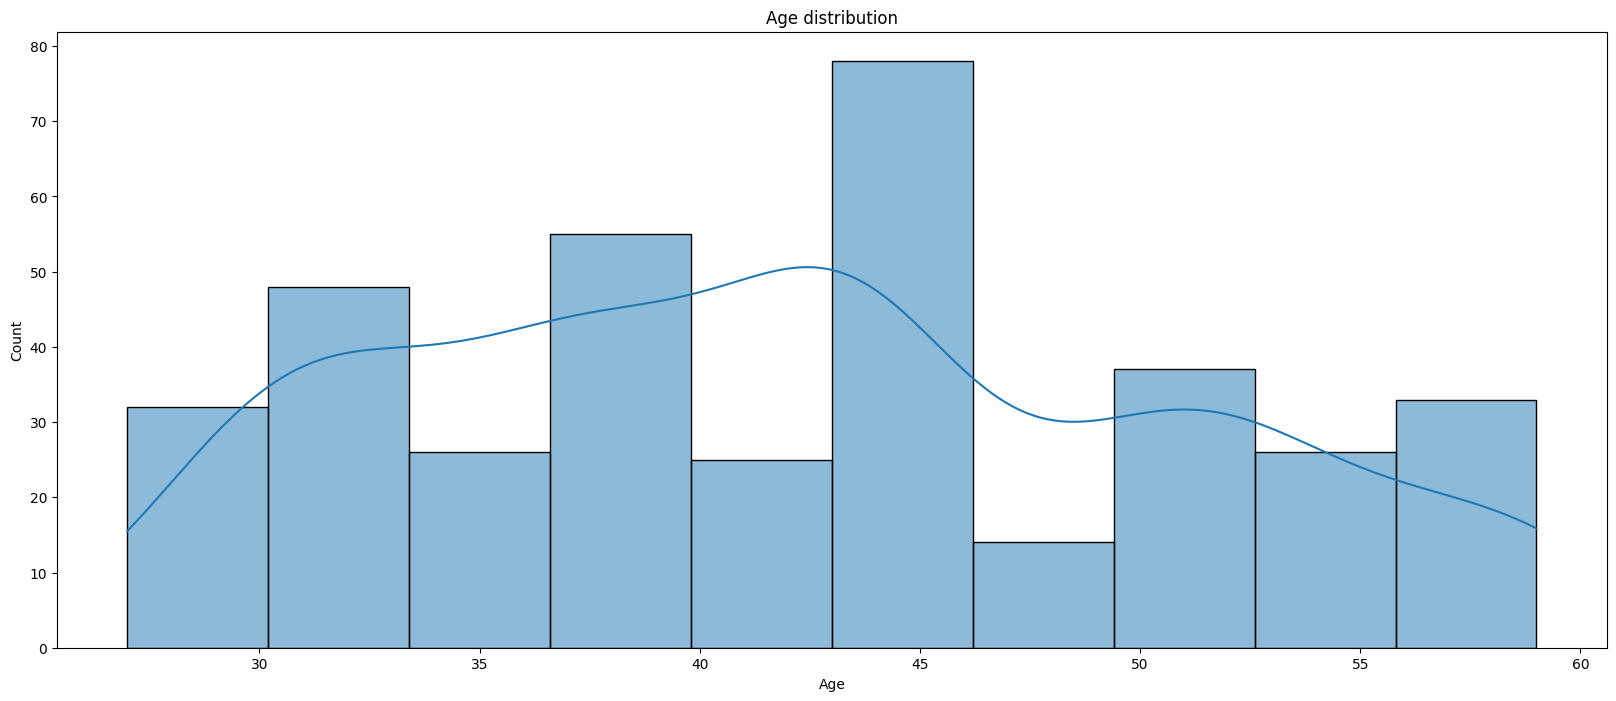

In [21]:
plt.figure(figsize=(20, 8))
sns.histplot(data=df['Age'], kde=True)
plt.title("Age distribution")
plt.show()

In [22]:
print(f"Minimum age: {np.min(df['Age'])}, Maximum age: {np.max(df['Age'])}")

Minimum age: 27, Maximum age: 59


-   So as we can see the minimum age in dataset is 27 and maximum is 59.
-   Age is not normally distributed in this data sample.


In [23]:
df.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder'],
      dtype='object')

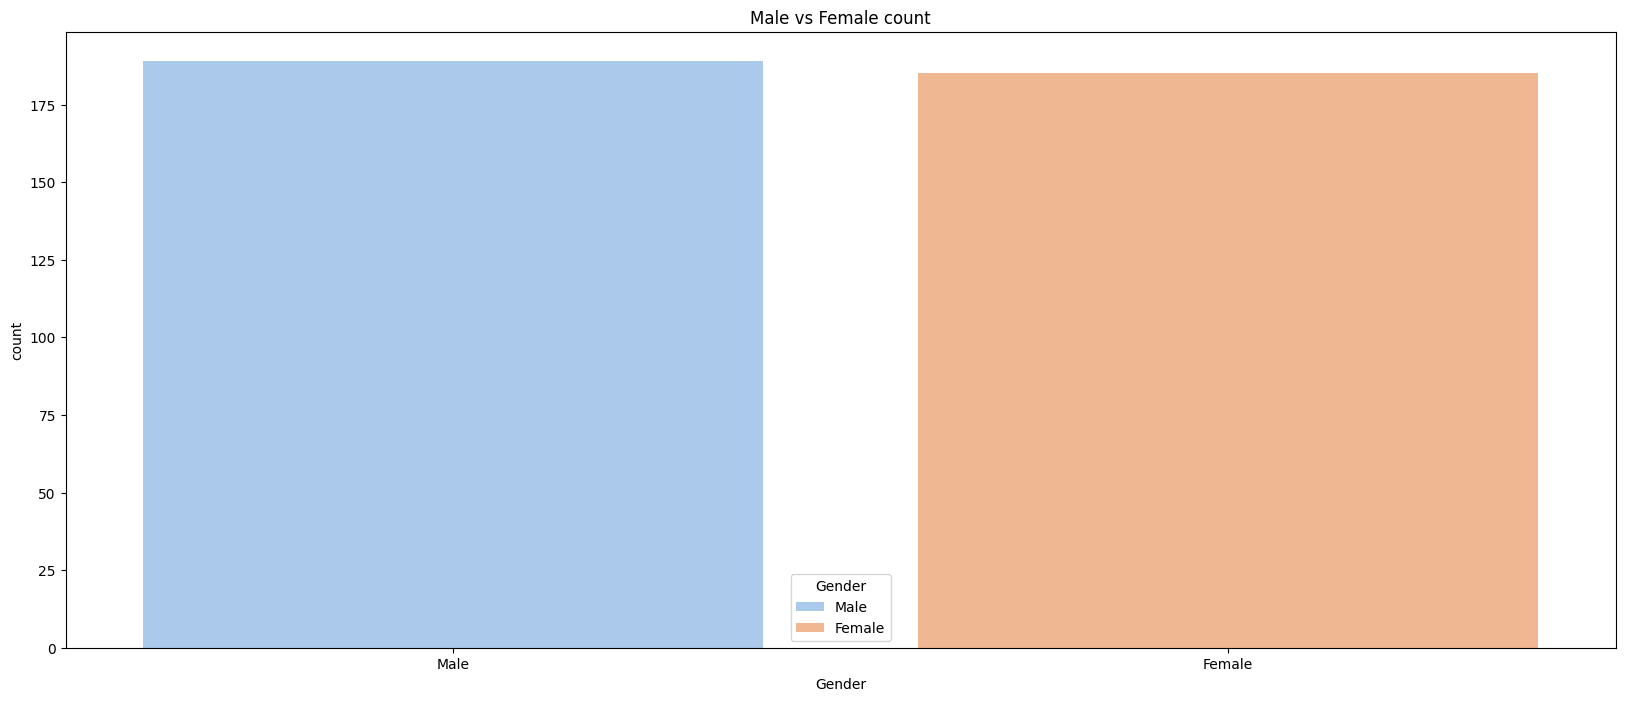

In [24]:
plt.figure(figsize=(20, 8))
sns.countplot(data=df, x='Gender', palette='pastel', hue='Gender', legend=True)
plt.title("Male vs Female count")
plt.show()

-   So there is no difference between male and female count in dataset.


<Axes: xlabel='Occupation', ylabel='Sleep Duration'>

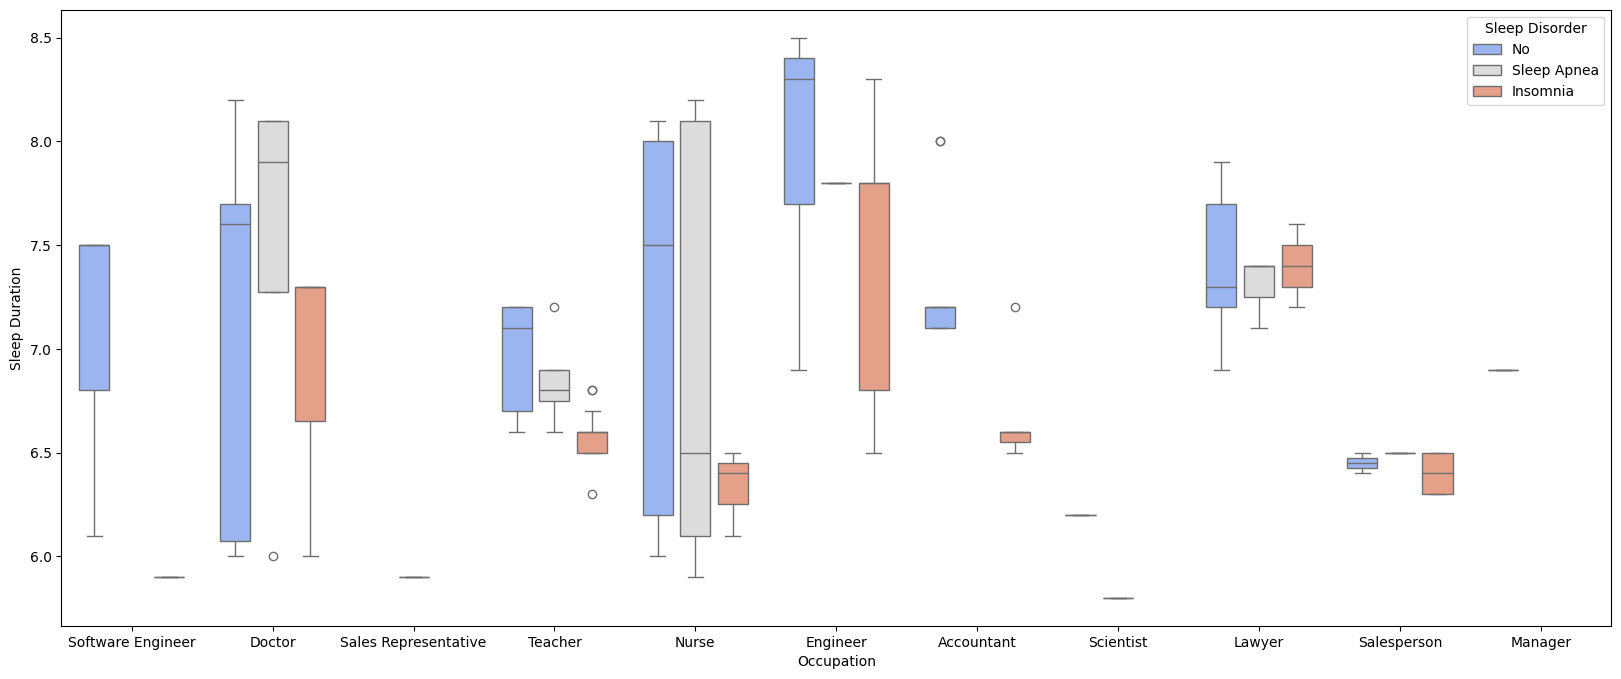

In [25]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df, x='Occupation', y='Sleep Duration', palette='coolwarm', hue='Sleep Disorder', orient='v', gap=0.2)

-   So as we can see that there is a lot of variation in sleep for Doctors and Engineer Occupation.
-   Most of the people who have insomnia are these people.
-   Sleep apnea is mostly found in nurse and doctors.
-   So as we can see people who save use are the people suffering for sleep disorder.
-   Conclusion so sleeping duration has no relation with having or not having sleep disorder, as we can see that people with disorder are all over the place.


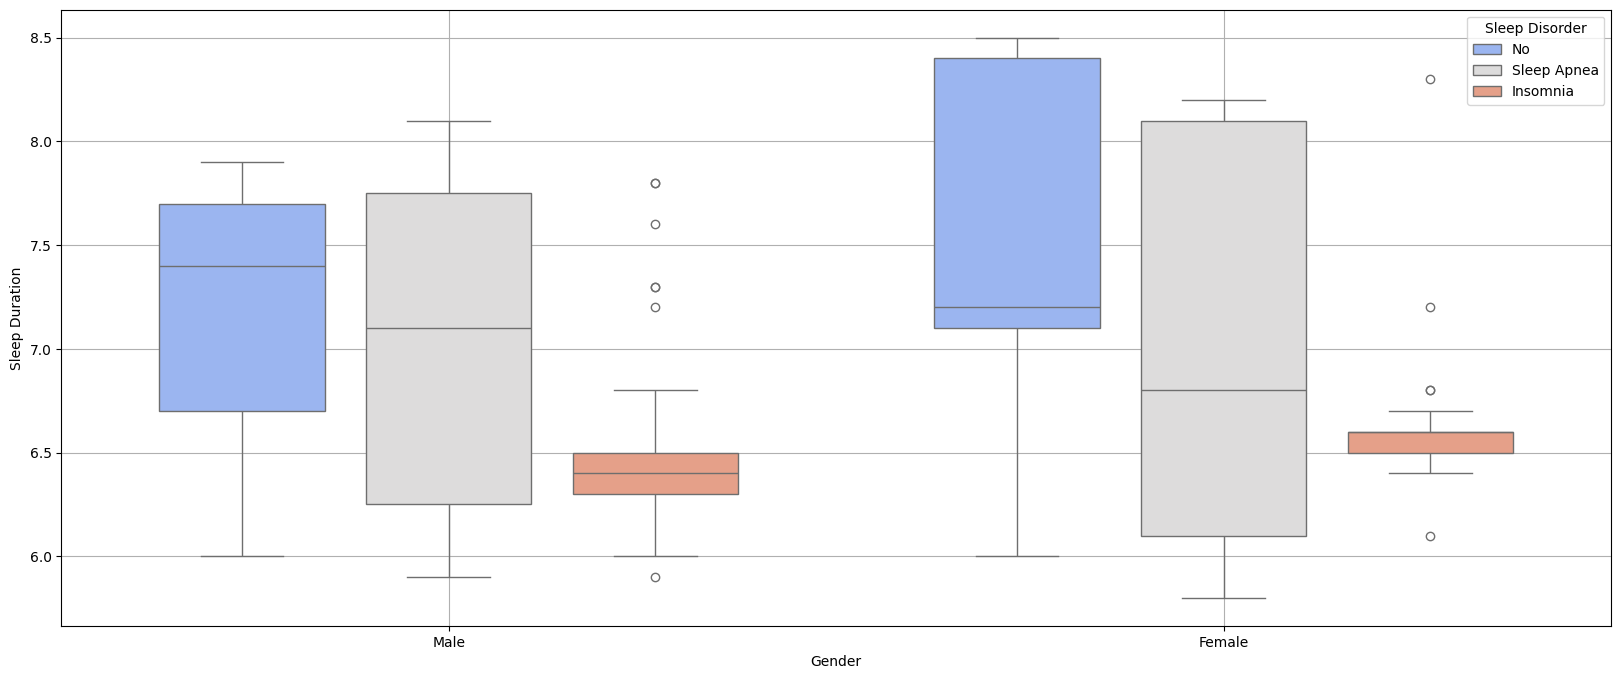

In [26]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df, x='Gender', y='Sleep Duration', palette='coolwarm', hue='Sleep Disorder', orient='v', gap=0.2)
plt.grid()

-   We can see that there is a relation between gender and sleeping disorder.
-   So females suffer more from sleep apnea and male suffer more from insomnia.
-   But we can also that female who have no sleep disorder 75% of them have sleep duration of more the 7 hours.
-   So we can say that if female sleep for more then 7 hours there will be less chances for them of suffering from sleeping disorder.
-   For males there is some other other factor, as we can see that 100% of male who do not have any sleep disorder fall in the same range of sleep duration as male suffering from sleep disorder.


In [27]:
df['BP Ratio'] = df['Blood Pressure'].apply(lambda x: round(float(x.split("/")[0]) / float(x.split("/")[1]), 2))

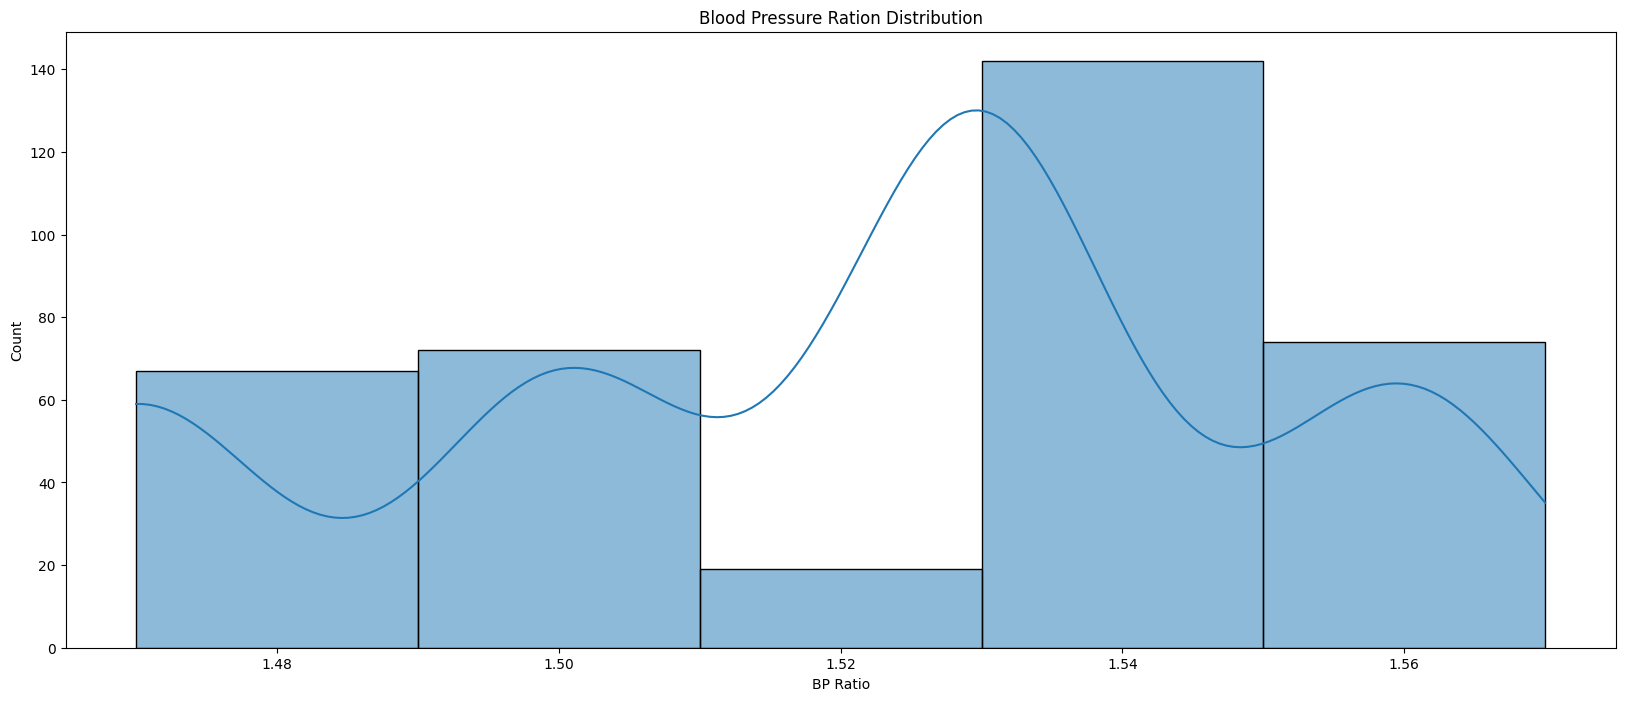

In [28]:
plt.figure(figsize=(20, 8))
sns.histplot(data=df, x='BP Ratio', bins=5, kde=True)
plt.title("Blood Pressure Ration Distribution")
plt.show()

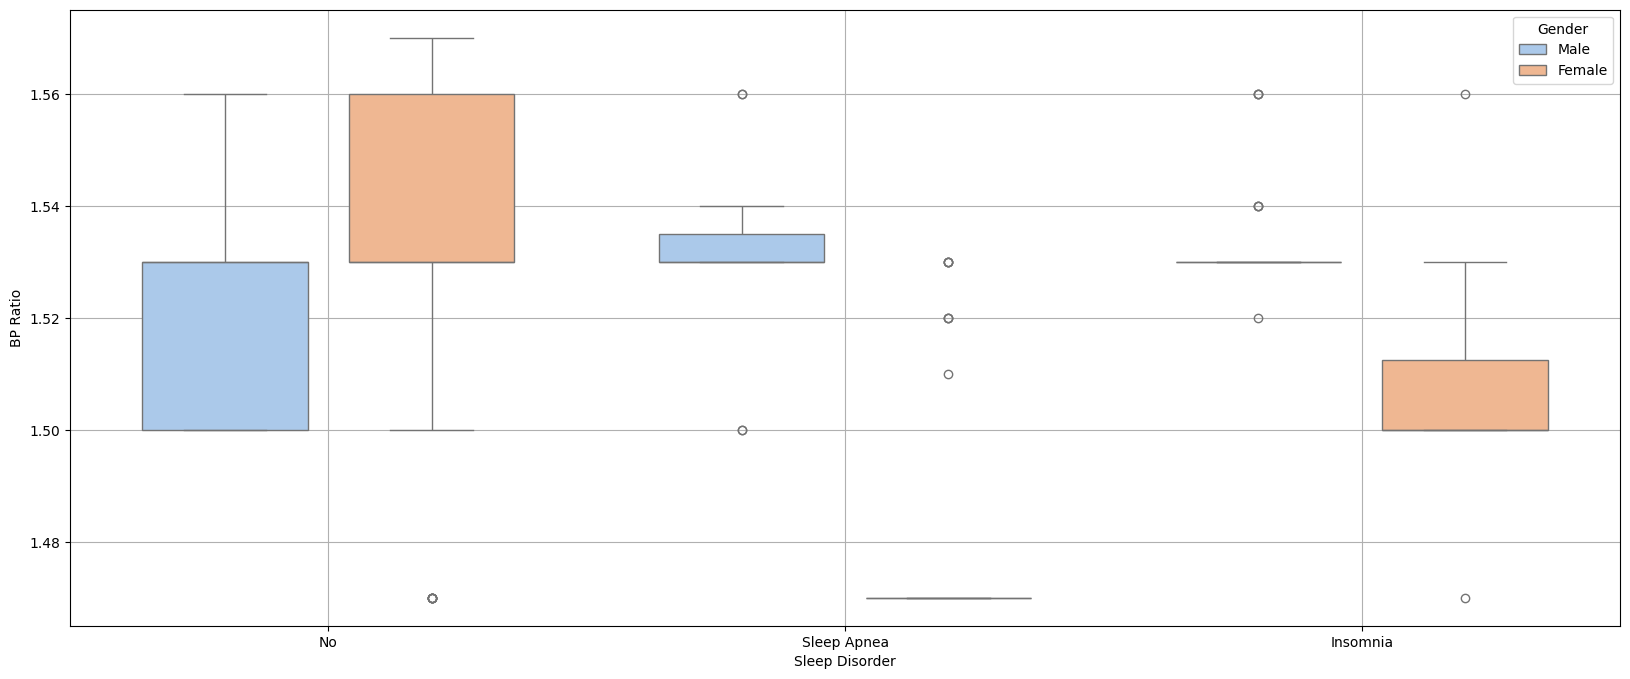

In [29]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df, x="Sleep Disorder", y="BP Ratio", hue="Gender", palette="pastel", gap=0.2)
plt.grid()
plt.show()

In [30]:
print(
    f"Blood pressure is normal when systolic less than: 120 and diastolic less than: 80 so BP Ration is less than {120/80} (Normal)"
)
print(
    f"At Risk when Blood pressure systolic is in between: 120-139 and diastolic in between: 80-89 so BP Ration is between {round(120/80, 2)} and {round(139/89, 2)} (pre hypertension)"
)
print(
    f"High Blood Pressure when Blood pressure systolic is more than: 140 and diastolic is more than: 90 so BP Ration more than {round(140/90, 2)} (hypertension)"
)

Blood pressure is normal when systolic less than: 120 and diastolic less than: 80 so BP Ration is less than 1.5 (Normal)
At Risk when Blood pressure systolic is in between: 120-139 and diastolic in between: 80-89 so BP Ration is between 1.5 and 1.56 (pre hypertension)
High Blood Pressure when Blood pressure systolic is more than: 140 and diastolic is more than: 90 so BP Ration more than 1.56 (hypertension)


-   So BP has no relation with sleep disorder as most of the people have BP Ration more then 1.5 which is not normal.
-   Most of the people are suffering from pre hypertension with respect to range specified above.


In [31]:
df.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'BP Ratio'],
      dtype='object')

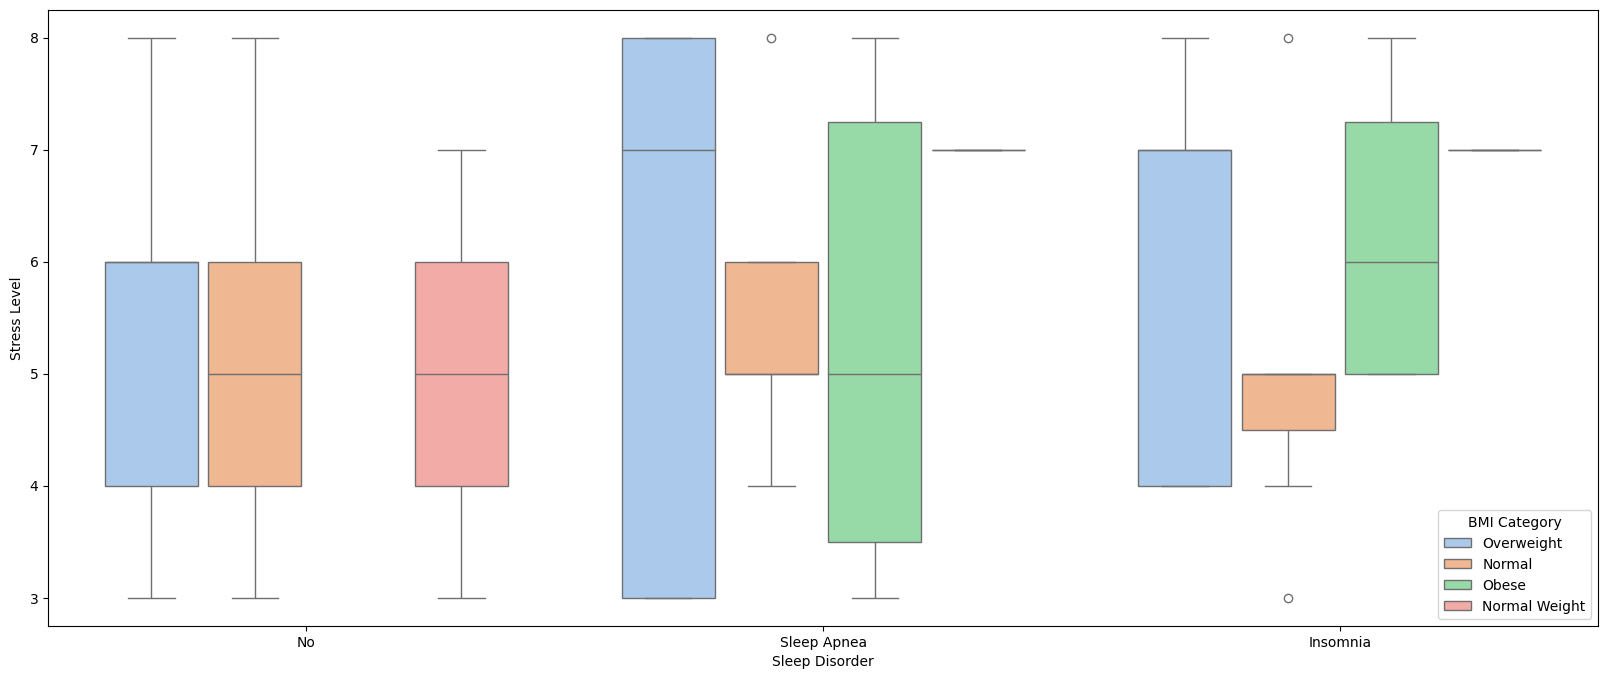

In [32]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df, x='Sleep Disorder', y='Stress Level', hue='BMI Category', palette='pastel', gap=0.1)
plt.show()

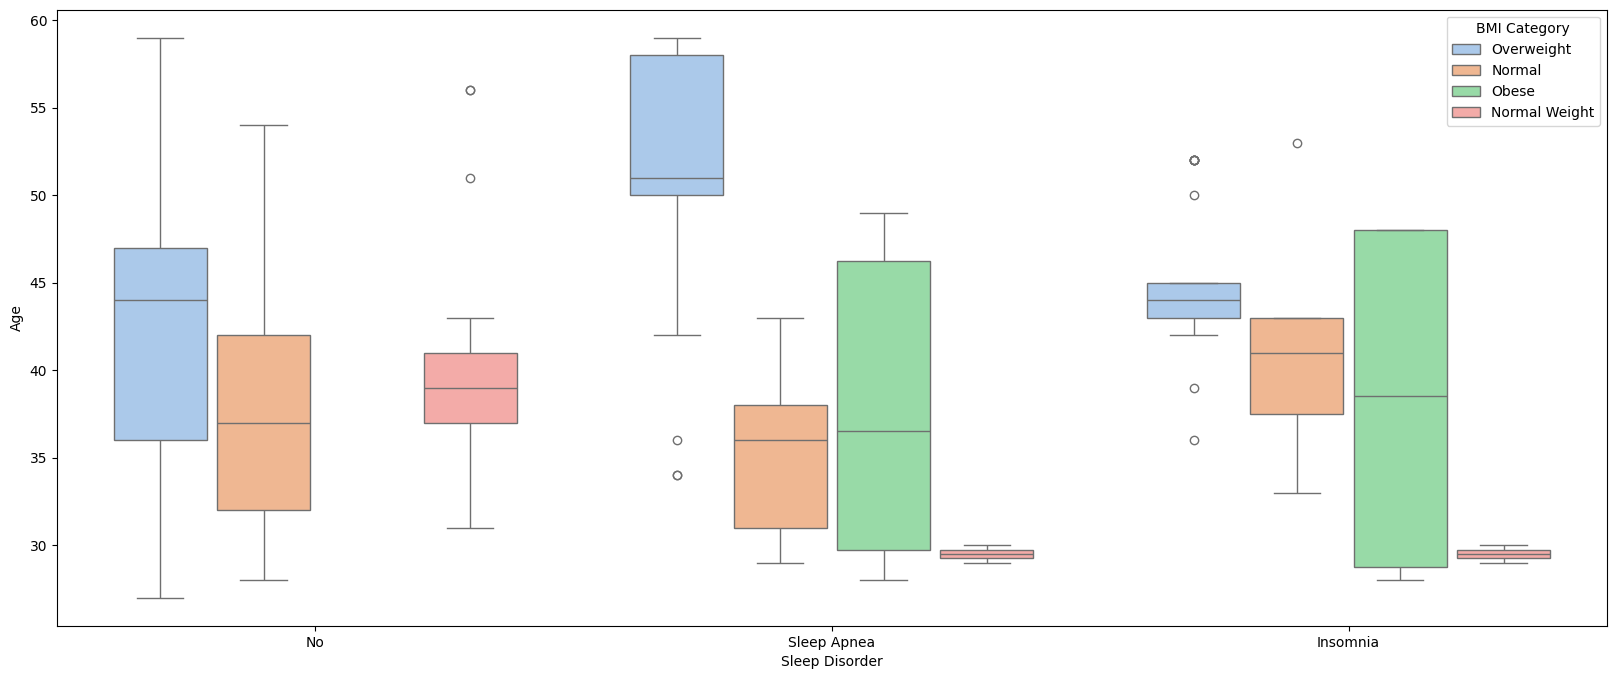

In [33]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df, x='Sleep Disorder', y='Age', hue='BMI Category', palette='pastel', gap=0.1)
plt.show()

#### Data Label Encoding


In [34]:
X = df.drop(columns=['Sleep Disorder', 'Blood Pressure'])
y = df['Sleep Disorder']

In [35]:
cate_col = X.select_dtypes(include='object').columns
num_col = X.select_dtypes(exclude='object').columns

cate_col, num_col

(Index(['Gender', 'Occupation', 'BMI Category'], dtype='object'),
 Index(['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
        'Stress Level', 'Heart Rate', 'Daily Steps', 'BP Ratio'],
       dtype='object'))

In [36]:
cate_pipe = Pipeline([("OneHotEncoder", OneHotEncoder())])

preprocessor = ColumnTransformer([("cate", cate_pipe, cate_col)])

In [37]:
X_cate = preprocessor.fit_transform(X[cate_col])
X_cate = pd.DataFrame.sparse.from_spmatrix(X_cate, columns=preprocessor.get_feature_names_out())
X_cate

,cate__Gender_Female,cate__Gender_Male,cate__Occupation_Accountant,cate__Occupation_Doctor,cate__Occupation_Engineer,cate__Occupation_Lawyer,cate__Occupation_Manager,cate__Occupation_Nurse,cate__Occupation_Sales Representative,cate__Occupation_Salesperson,cate__Occupation_Scientist,cate__Occupation_Software Engineer,cate__Occupation_Teacher,cate__BMI Category_Normal,cate__BMI Category_Normal Weight,cate__BMI Category_Obese,cate__BMI Category_Overweight
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
370,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
371,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
372,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
X = pd.concat([X[num_col], X_cate], axis=1)
y = y.replace({"No": 0, "Sleep Apnea": 1, "Insomnia": 2})
data = pd.concat([X, y], axis=1)
train, test = train_test_split(data, test_size=0.3)

In [39]:
train.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,BP Ratio,cate__Gender_Female,cate__Gender_Male,...,cate__Occupation_Sales Representative,cate__Occupation_Salesperson,cate__Occupation_Scientist,cate__Occupation_Software Engineer,cate__Occupation_Teacher,cate__BMI Category_Normal,cate__BMI Category_Normal Weight,cate__BMI Category_Obese,cate__BMI Category_Overweight,Sleep Disorder
62,32,6.2,6,30,8,72,5000,1.56,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
325,53,8.5,9,30,3,65,5000,1.56,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
102,36,7.2,8,60,4,68,7000,1.53,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
253,45,6.5,7,45,4,65,6000,1.50,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
330,53,8.5,9,30,3,65,5000,1.56,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


#### FINISH
